# Εργαστηριακή Άσκηση Υπολογιστικής Νοημοσύνης
## Μερος Β. Αποκατάσταση αρχαίων επιγραφών με χρήση ΓΑ.

Όνομα: Ζαχουλίτης Κωνσταντίνος Γεώργιος <br/>
ΑΜ: 1072578 <br/>
Έτος: 5ο <br/>
Email: up1072578@ac.upatras.gr

### Περιβάλλον Υλοποίησης
CPU:    AMD 6-core 64-bit <br/>
Memory: 16 GB
OS:     Windows 11 23H2 <br/>
Python: 3.12.3 <br/>
IDE:    Pycharm Professional, VS Code

### Β1. Σχεδιασμός ΓΑ

#### α) Κωδικοποίηση

In [4]:
import random
import warnings
import numpy as np
import pandas as pd
from deap import base, creator, tools, algorithms
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

df = pd.read_csv("../iphi2802.csv", delimiter="\t", encoding='utf-8')
df=df[df['region_main_id'] == 1683] #Επιλέγουμε μόνο της περιοχής
inscriptions = df['text']

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(inscriptions)
vocabulary = vectorizer.get_feature_names_out()

#Θελουμε μέγιστη fitness value για κάθε individual
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)
toolbox = base.Toolbox()

#### β) Πλεονάζουσες τιμές

In [5]:
print('-'*10)

----------


#### γ) Αρχικός πληθυσμός

In [6]:
def create_individual(icls):
    return icls([random.randint(0, len(vocabulary)-1) for _ in range(2)])
# Δημιουργουμε individuals με βάση την κλάση creator.Individual που ορίσαμε πάνω
toolbox.register("individual", create_individual, creator.Individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

#### δ) Υπολογισμός ομοιότητας &

#### ε) Συνάρτηση καταλληλότητας

In [259]:
def evaluate(individual):
    words = [vocabulary[i] for i in individual]
    completed_inscription = f"{words[0]} αλεξανδρε ουδις {words[1]}"
    
    completed_vector = vectorizer.transform([completed_inscription])
    #Ομοιότητα συνημιτόνου
    similarities = cosine_similarity(completed_vector, tfidf_matrix)
    return (np.mean(similarities[0][:5]),)  #top 5 

toolbox.register("evaluate", evaluate)

#### στ) Γενετικοί τελεστές

In [362]:
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", tools.cxUniform,indpb=0.1)
toolbox.register("mutate", tools.mutUniformInt, low=0, up=len(vocabulary)-1, indpb=0.3)

### Β2. Υλοποίηση ΓΑ 

In [363]:
def main(POP, CXPB, MUTPB, LAMBDA, MU, NGEN, max_no_improve=10, min_improve=0.01):
    pop = toolbox.population(n=POP)
    hof = tools.HallOfFame(1) # Καλύτερη λύση
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    best_fitness_prev = None
    generations_no_improve = 0

    for gen in range(NGEN):
        pop, log = algorithms.eaMuPlusLambda(pop, toolbox, mu=MU, lambda_=LAMBDA, cxpb=CXPB, mutpb=MUTPB, 
                                             ngen=1, stats=stats, halloffame=hof, verbose=False)

        best = hof[0]
        best_fitness = best.fitness.values[0]

        if best_fitness_prev is not None:
            fitness_diff = best_fitness - best_fitness_prev

            if fitness_diff <= 0: 
                generations_no_improve += 1
            else:
                generations_no_improve = 0  # Reset if improvement
            
            if generations_no_improve >= max_no_improve:
                print(f"Terminating: No improvement for {max_no_improve} generations.")
                break

            if abs(fitness_diff) / best_fitness_prev < min_improve:
                print(f"Terminating: Improvement is less than the minimum {min_improve} threshold.")
                break   
        
        best_fitness_prev = best_fitness

        if gen == NGEN - 1:
            print(f"Terminating: Reached maximum number of {NGEN} generations.")
            break
    
    best_words = [vocabulary[i] for i in best]
    best_inscr = f'{best_words[0]} αλεξανδρε ουδις {best_words[1]}'
    print(f"\tBest solution: {best_inscr}")
    print(f"\tFitness: {best_fitness}")

    return pop, log, hof, best_fitness, best_inscr, [POP, CXPB, MUTPB, gen]# stats

### Β3. Αξιολόγηση και Επίδραση Παραμέτρων

#### α) Εκτέλεση του αλγορίθμου για τις τιμές των δοθέντων παραμέτρων.

In [364]:
POP = [20]*5 + [200] *5
CXPB = [0.6, 0.6, 0.6, 0.9, 0.1]*2
MUTPB = [0.00, 0.01, 0.10, 0.01, 0.01]*2

if __name__ == "__main__":
    FITNS=[]
    for iter in range(10): #τρέχουμε 10 φορες
        print(f'Iteration: {iter}')
        for i in range(10): # τρέχουμε για τους 10 συνδυασμούς
            LAMBDA = POP[i] * 10# // 2 + 2
            MU = LAMBDA // 2 + 1
            NGEN = (LAMBDA + 1) * 2
            no_improve = NGEN // 2 + 1
            _, log, _, best, inscr, stats = main(POP[i], CXPB[i], MUTPB[i], LAMBDA, MU, NGEN, max_no_improve=no_improve)
            print(f'\tBest for Iter: {best}, Inscription: {inscr}')
            FITNS.append([best, inscr, stats, log])
    print(FITNS)

Iteration: 0
Terminating: Improvement is less than the minimum 0.01 threshold.
	Best solution: υς αλεξανδρε ουδις φω
	Fitness: 0.13026031558849133
	Best for Iter: 0.13026031558849133, Inscription: υς αλεξανδρε ουδις φω
Terminating: Improvement is less than the minimum 0.01 threshold.
	Best solution: αγνως αλεξανδρε ουδις ασυνκ
	Fitness: 0.03310854805244755
	Best for Iter: 0.03310854805244755, Inscription: αγνως αλεξανδρε ουδις ασυνκ
Terminating: Improvement is less than the minimum 0.01 threshold.
	Best solution: και αλεξανδρε ουδις αριστογενους
	Fitness: 0.0700635329437311
	Best for Iter: 0.0700635329437311, Inscription: και αλεξανδρε ουδις αριστογενους
Terminating: Improvement is less than the minimum 0.01 threshold.
	Best solution: συμφεροντ αλεξανδρε ουδις τω
	Fitness: 0.048825795056401715
	Best for Iter: 0.048825795056401715, Inscription: συμφεροντ αλεξανδρε ουδις τω
Terminating: Improvement is less than the minimum 0.01 threshold.
	Best solution: κρατιστη αλεξανδρε ουδις δημητριο

C:\Users\kzach\AppData\Local\Temp\ipykernel_21532\296150003.py:32: RuntimeWarning: invalid value encountered in scalar divide
  if abs(fitness_diff) / best_fitness_prev < min_improve:


Terminating: No improvement for 202 generations.
	Best solution: ιος αλεξανδρε ουδις πρωτογενην
	Fitness: 0.0
	Best for Iter: 0.0, Inscription: ιος αλεξανδρε ουδις πρωτογενην


C:\Users\kzach\AppData\Local\Temp\ipykernel_21532\296150003.py:32: RuntimeWarning: divide by zero encountered in scalar divide
  if abs(fitness_diff) / best_fitness_prev < min_improve:


Terminating: Improvement is less than the minimum 0.01 threshold.
	Best solution: πι αλεξανδρε ουδις ων
	Fitness: 0.010378556917807856
	Best for Iter: 0.010378556917807856, Inscription: πι αλεξανδρε ουδις ων
Terminating: Improvement is less than the minimum 0.01 threshold.
	Best solution: χαιρετε αλεξανδρε ουδις και
	Fitness: 0.12280199386459745
	Best for Iter: 0.12280199386459745, Inscription: χαιρετε αλεξανδρε ουδις και
Terminating: Improvement is less than the minimum 0.01 threshold.
	Best solution: ογενους αλεξανδρε ουδις περσεφονηι
	Fitness: 0.06096113780483555
	Best for Iter: 0.06096113780483555, Inscription: ογενους αλεξανδρε ουδις περσεφονηι
Terminating: Improvement is less than the minimum 0.01 threshold.
	Best solution: ιακχωι αλεξανδρε ουδις ντα
	Fitness: 0.07506317133791011
	Best for Iter: 0.07506317133791011, Inscription: ιακχωι αλεξανδρε ουδις ντα
Terminating: Improvement is less than the minimum 0.01 threshold.
	Best solution: αφ αλεξανδρε ουδις συριηι
	Fitness: 0.141421

#### β) Σχεδιασμός της καμπύλης εξέλιξης (απόδοση/αριθμό γενιών) της καλύτερης λύσης 

In [365]:
# Παιρνουμε το καλύτερο αποτέλεσμα μαζί με όλα τα στοιχεία
max_best = max([fitn[0] for fitn in FITNS])
max_best_list = [fitn for fitn in FITNS if fitn[0] == max_best][0]
print(max_best_list)

[0.14734864580001922, 'συριηι αλεξανδρε ουδις μητρω', [200, 0.6, 0.1, 3], [{'gen': 0, 'nevals': 0, 'avg': 0.07219117826235229, 'std': 0.018622459851459282, 'min': 0.016554274026223774, 'max': 0.14734864580001922}, {'gen': 1, 'nevals': 1408, 'avg': 0.09259038293322826, 'std': 0.02029414372449237, 'min': 0.05850889731168635, 'max': 0.14734864580001922}]]


In [366]:
import matplotlib.pyplot as plt

def plot_evolution_curves(results):
    OVERALL = []
    fig, axs = plt.subplots(2, 5, figsize=(20, 10))
    for group_index in range(10):
       
        # Ομαδοποιούμε με βάση το modulo για να πάρουμε τα στοχεια των ίδων συνδυασμων
        # Πχ τα 0,10,20... εχουν [POP = 20, CX = 0.6, MUT = 0.0], ομοιώς για τα 1,11,21 κλπ
        batch = [results[i] for i in range(group_index, len(results), 10)]
        fitness = []
        stats_string = ''
        row = group_index // 5
        col = group_index % 5

        for best, _, stats, _ in batch:
            fitness.append(best)
            stats_string = f"P:{stats[0]}, C:{stats[1]}, M:{stats[2]}, G: {stats[3]}"
        
        OVERALL.append([np.average(fitness), stats_string])

        axs[row, col].plot(fitness)
        axs[row, col].set_title(stats_string)
        axs[row, col].set_xlabel("Generation")
        axs[row, col].set_ylabel("Fitness")


    plt.tight_layout()
    plt.savefig(f"./evolution_curves.png")
    plt.show()
    plt.close()
    return OVERALL

#Αναλύουμε πόσο επηρέασε κάθε παράμετρος ξεχωριστά
def analyze_results(results):
    pop_sizes = [20, 200]
    cx_probs = [0.1, 0.6, 0.9]
    mut_probs = [0.00, 0.01, 0.10]

    for pop in pop_sizes:
        pop_results = [r for r in results if r[2][0] == pop]
        avg_fitness = np.mean([r[0] for r in pop_results])
        print(f"Average fitness for population size {pop}: {avg_fitness}")

    for cx in cx_probs:
        cx_results = [r for r in results if r[2][1] == cx]
        avg_fitness = np.mean([r[0] for r in cx_results])
        print(f"Average fitness for crossover probability {cx}: {avg_fitness}")

    for mut in mut_probs:
        mut_results = [r for r in results if r[2][2] == mut]
        avg_fitness = np.mean([r[0] for r in mut_results])
        print(f"Average fitness for mutation probability {mut}: {avg_fitness}")

    # Find best overall solution
    best_solution = max(results, key=lambda x: x[0])
    print(f"Best overall solution: {best_solution[1]} with fitness {best_solution[0]}")
    print(
        f"Parameters: Pop size: {best_solution[2][0]}, CX prob: {best_solution[2][1]}, Mut prob: {best_solution[2][2]}"
    )

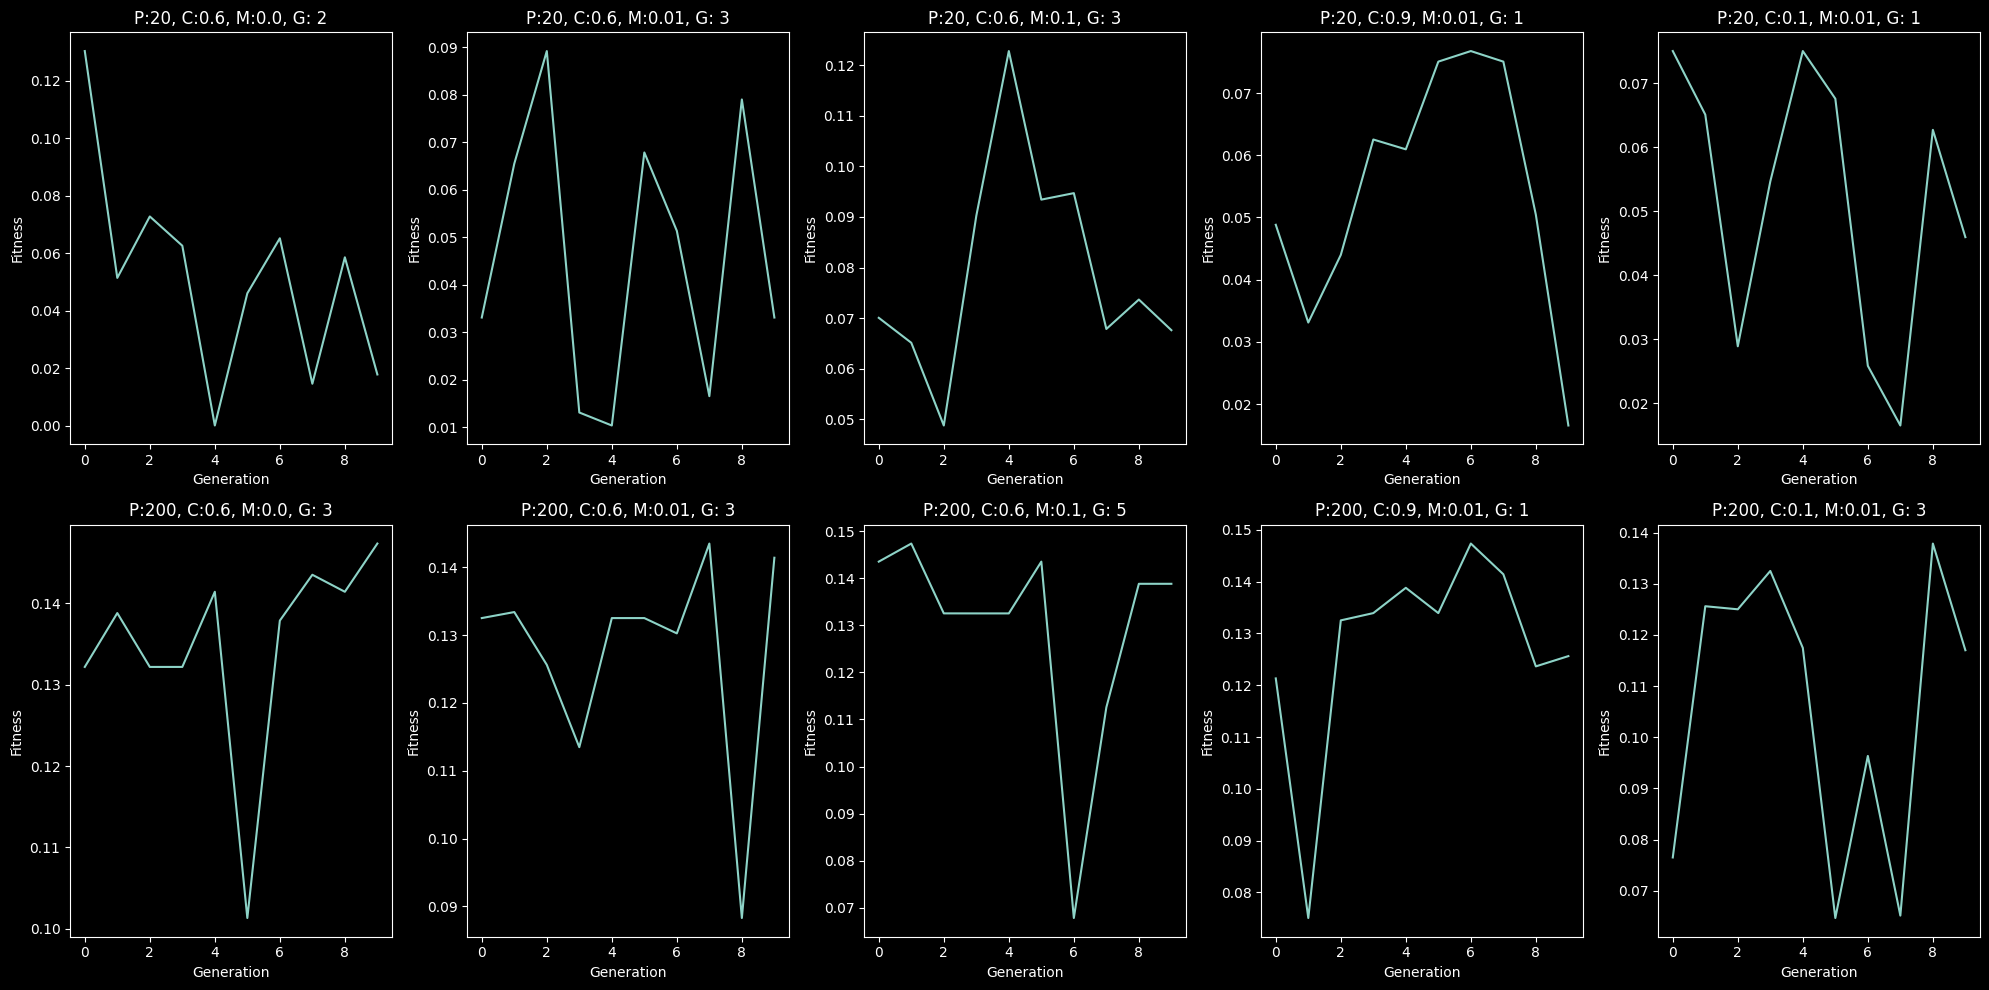

Average fitness for population size 20: 0.056665128188234465
Average fitness for population size 200: 0.12486996346508994
Average fitness for crossover probability 0.1: 0.07879152908131466
Average fitness for crossover probability 0.6: 0.09473419667054699
Average fitness for crossover probability 0.9: 0.09084361004035532
Average fitness for mutation probability 0.0: 0.09335190431644634
Average fitness for mutation probability 0.01: 0.08542396061868321
Average fitness for mutation probability 0.1: 0.10421394296081501
Best overall solution: συριηι αλεξανδρε ουδις μητρω with fitness 0.14734864580001922
Parameters: Pop size: 200, CX prob: 0.6, Mut prob: 0.1


In [367]:
average = plot_evolution_curves(FITNS)
analyze_results(FITNS)

#### γ) Συμπεράσματά σχετικά με την επίδραση της κάθε παραμέτρου(μέγεθος πληθυσμού, πιθανότητα διασταύρωσης, πιθανότητα μετάλλαξης) στη σύγκλιση του αλγορίθμου

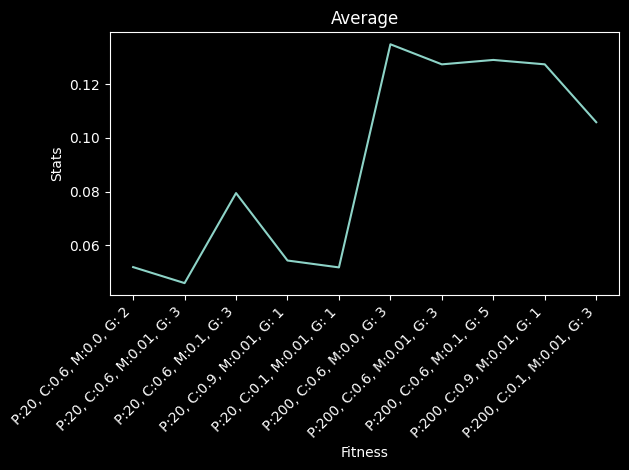

In [368]:
avg_fit = [i[0] for i in average]
fit_stats = [i[1] for i in average]

plt.plot(fit_stats, avg_fit)
plt.title("Average")
plt.xlabel("Fitness")
plt.ylabel("Stats")
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()
plt.savefig("./Average Fitness.png")
plt.show()
plt.close()

In [369]:
for i in range(len(average)):
    print(f'Best Solution for {average[i][1]}: {average[i][0]}')

Best Solution for P:20, C:0.6, M:0.0, G: 2: 0.051878320815148926
Best Solution for P:20, C:0.6, M:0.01, G: 3: 0.04592082857207717
Best Solution for P:20, C:0.6, M:0.1, G: 3: 0.0794297758331501
Best Solution for P:20, C:0.9, M:0.01, G: 1: 0.05432947902556865
Best Solution for P:20, C:0.1, M:0.01, G: 1: 0.0517672366952275
Best Solution for P:200, C:0.6, M:0.0, G: 3: 0.13482548781774376
Best Solution for P:200, C:0.6, M:0.01, G: 3: 0.12735265689668204
Best Solution for P:200, C:0.6, M:0.1, G: 5: 0.12899811008847992
Best Solution for P:200, C:0.9, M:0.01, G: 1: 0.12735774105514203
Best Solution for P:200, C:0.1, M:0.01, G: 3: 0.10581582146740183
